In [1]:
! git clone https://github.com/YhBedoya/ImageMAE.git

Cloning into 'ImageMAE'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 65 (delta 32), reused 53 (delta 20), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [2]:
!pip install timm=="0.3.2"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 244 kB 7.3 MB/s 


In [3]:
import os
os.chdir("/content/ImageMAE")

The following is a necessary fix in the file /usr/local/lib/python3.7/dist-packages/timm/models/layers/helpers.py



```
import torch
from itertools import repeat
TORCH_MAJOR = int(torch.__version__.split('.')[0])
TORCH_MINOR = int(torch.__version__.split('.')[1])

if TORCH_MAJOR == 1 and TORCH_MINOR < 8:
    from torch._six import container_abcs
else:
    import collections.abc as container_abcs
```



### Training phase

In [4]:
from main_pretrain import get_args_parser
from main_pretrain import main
from pathlib import Path

In [5]:
args = get_args_parser()
args.add_argument('-f')
args = args.parse_args()

In [6]:
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
main(args)

Not using distributed mode
[22:40:59.845424] job dir: /content/ImageMAE
[22:40:59.845612] Namespace(accum_iter=1,
batch_size=64,
blr=0.001,
data_path='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/',
device='cuda',
dist_on_itp=False,
dist_url='env://',
distributed=False,
epochs=50,
f='/root/.local/share/jupyter/runtime/kernel-cf3c7cc3-43c8-4542-ad15-1ec16f74d708.json',
input_size=64,
local_rank=-1,
log_dir='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir',
lr=None,
mask_ratio=0.75,
min_lr=0.0,
model='mae_vit_large_patch16',
norm_pix_loss=False,
num_workers=10,
output_dir='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir',
pin_mem=True,
resume='',
seed=0,
start_epoch=0,
warmup_epochs=40,
weight_decay=0.05,
world_size=1)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:892: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


[22:41:24.007918] Dataset ImageFolder
    Number of datapoints: 4000
    Root location: /content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(64, 64), scale=(0.2, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
[22:41:24.009037] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7f1426c00290>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[22:41:38.670576] Model = MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(8, 8), stride=(8, 8))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate=none)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
   

In [8]:
import sys
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import models_mae

In [9]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

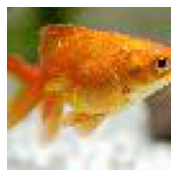

In [10]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open("/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/val/n01443537/n01443537_402.JPEG")
img = img.resize((64, 64))
img = np.array(img)  / 256

assert img.shape == (64, 64, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [3, 3]
show_image(torch.tensor(img))

In [11]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
#!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = '/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir/checkpoint.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

[23:09:06.919545] <All keys matched successfully>
[23:09:07.952944] Model loaded.


[23:09:08.013921] MAE with pixel reconstruction:


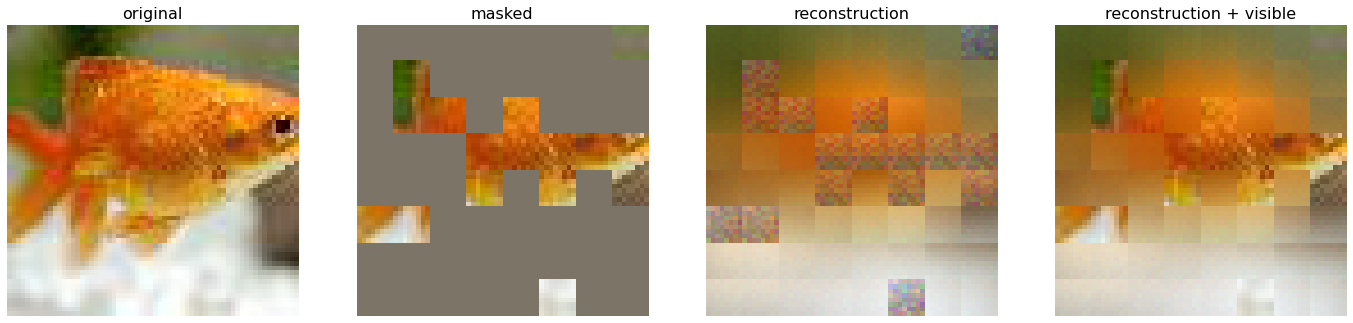

In [12]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Finetunning

In [13]:
from main_finetune import get_args_parser as get_args_parser_ft
from main_finetune import main as main_ft
from pathlib import Path

In [14]:
args = get_args_parser_ft()
args.add_argument('-f')
args = args.parse_args()

In [15]:
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)

In [16]:
main_ft(args)

[23:09:10.144035] Not using distributed mode
[23:09:10.144374] [23:09:10.144357] [23:09:10.144644] job dir: /content/ImageMAE
[23:09:10.144934] [23:09:10.144919] [23:09:10.145012] Namespace(aa='rand-m9-mstd0.5-inc1',
accum_iter=1,
batch_size=64,
blr=0.001,
clip_grad=None,
color_jitter=None,
cutmix=0,
cutmix_minmax=None,
data_path='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/',
device='cuda',
dist_eval=False,
dist_on_itp=False,
dist_url='env://',
distributed=False,
drop_path=0.1,
epochs=50,
eval=False,
f='/root/.local/share/jupyter/runtime/kernel-cf3c7cc3-43c8-4542-ad15-1ec16f74d708.json',
finetune='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir/checkpoint.pth',
global_pool=True,
input_size=64,
layer_decay=0.75,
local_rank=-1,
log_dir='/content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir',
lr=None,
min_lr=1e-06,
mixup=0,
mixup_mode='batch',
mixup_prob

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


[23:09:14.120978] [23:09:14.120949] [23:09:14.121153] Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/Data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bicubic, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
[23:09:14.121401] [23:09:14.121392] [23:09:14.122645] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7f13ad9f2e90>
[23:09:39.695029] [23:09:39.691291] [23:09:39.718054] Load pre-trained checkpoint from: /content/drive/MyDrive/Data Science and Engineering - PoliTo2/Thesis/models/mae-main/output_dir/checkpoint.pth
[23:09:40.072625] [23:09:40.072577] [23:09:40.072768] _IncompatibleKeys(missing_keys=['head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'], u

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:09:45.785571] [23:09:45.785536] [23:09:45.785754] Epoch: [0]  [ 0/62]  eta: 0:05:17  lr: 0.000000  loss: 2.3025 (2.3025)  time: 5.1156  data: 3.7876  max mem: 7530
[23:10:01.501280] [23:10:01.501258] [23:10:01.501407] Epoch: [0]  [20/62]  eta: 0:00:41  lr: 0.000016  loss: 2.3024 (2.3023)  time: 0.7857  data: 0.0005  max mem: 9393
[23:10:17.974203] [23:10:17.974184] [23:10:17.974330] Epoch: [0]  [40/62]  eta: 0:00:20  lr: 0.000032  loss: 2.3017 (2.3020)  time: 0.8236  data: 0.0006  max mem: 9393
[23:10:34.203530] [23:10:34.203505] [23:10:34.203699] Epoch: [0]  [60/62]  eta: 0:00:01  lr: 0.000048  loss: 2.2968 (2.2999)  time: 0.8114  data: 0.0004  max mem: 9393
[23:10:34.992105] [23:10:34.992084] [23:10:34.992231] Epoch: [0]  [61/62]  eta: 0:00:00  lr: 0.000049  loss: 2.2968 (2.2998)  time: 0.8091  data: 0.0003  max mem: 9393
[23:10:35.800809] [23:10:35.800783] [23:10:35.800951] Epoch: [0] Total time: 0:00:55 (0.8895 s / it)
[23:10:35.801832] [23:10:35.801816] [23:10:35.801933] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:11:24.497362] [23:11:24.497328] [23:11:24.497550] Epoch: [1]  [ 0/62]  eta: 0:04:04  lr: 0.000050  loss: 2.2979 (2.2979)  time: 3.9484  data: 2.9942  max mem: 9393
[23:11:40.408665] [23:11:40.408639] [23:11:40.408849] Epoch: [1]  [20/62]  eta: 0:00:39  lr: 0.000066  loss: 2.2872 (2.2877)  time: 0.7955  data: 0.0006  max mem: 9393
[23:11:57.098660] [23:11:57.098636] [23:11:57.100639] Epoch: [1]  [40/62]  eta: 0:00:19  lr: 0.000082  loss: 2.2801 (2.2834)  time: 0.8344  data: 0.0005  max mem: 9393
[23:12:13.524536] [23:12:13.524489] [23:12:13.524683] Epoch: [1]  [60/62]  eta: 0:00:01  lr: 0.000098  loss: 2.2424 (2.2726)  time: 0.8211  data: 0.0003  max mem: 9393
[23:12:14.328216] [23:12:14.328194] [23:12:14.328344] Epoch: [1]  [61/62]  eta: 0:00:00  lr: 0.000099  loss: 2.2424 (2.2716)  time: 0.8194  data: 0.0003  max mem: 9393
[23:12:15.142864] [23:12:15.142844] [23:12:15.143739] Epoch: [1] Total time: 0:00:54 (0.8806 s / it)
[23:12:15.143875] [23:12:15.143868] [23:12:15.143925] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:12:28.430053] [23:12:28.430022] [23:12:28.431521] Epoch: [2]  [ 0/62]  eta: 0:04:59  lr: 0.000100  loss: 2.1537 (2.1537)  time: 4.8361  data: 3.5231  max mem: 9393
[23:12:44.128246] [23:12:44.128220] [23:12:44.129896] Epoch: [2]  [20/62]  eta: 0:00:41  lr: 0.000116  loss: 2.2026 (2.1931)  time: 0.7848  data: 0.0005  max mem: 9393
[23:13:00.245006] [23:13:00.244976] [23:13:00.245267] Epoch: [2]  [40/62]  eta: 0:00:19  lr: 0.000132  loss: 2.1542 (2.1770)  time: 0.8055  data: 0.0008  max mem: 9393
[23:13:16.515642] [23:13:16.515619] [23:13:16.515773] Epoch: [2]  [60/62]  eta: 0:00:01  lr: 0.000148  loss: 2.1582 (2.1714)  time: 0.8135  data: 0.0004  max mem: 9393
[23:13:17.314824] [23:13:17.314803] [23:13:17.316210] Epoch: [2]  [61/62]  eta: 0:00:00  lr: 0.000149  loss: 2.1582 (2.1720)  time: 0.8130  data: 0.0003  max mem: 9393
[23:13:18.167534] [23:13:18.167514] [23:13:18.167720] Epoch: [2] Total time: 0:00:54 (0.8806 s / it)
[23:13:18.167844] [23:13:18.167837] [23:13:18.167891] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:13:29.206859] [23:13:29.206828] [23:13:29.209401] Epoch: [3]  [ 0/62]  eta: 0:03:49  lr: 0.000150  loss: 2.0486 (2.0486)  time: 3.6957  data: 2.7176  max mem: 9393
[23:13:45.194550] [23:13:45.194526] [23:13:45.194740] Epoch: [3]  [20/62]  eta: 0:00:39  lr: 0.000166  loss: 2.1084 (2.1180)  time: 0.7992  data: 0.0004  max mem: 9393
[23:14:01.448454] [23:14:01.448436] [23:14:01.449142] Epoch: [3]  [40/62]  eta: 0:00:19  lr: 0.000182  loss: 2.1127 (2.1238)  time: 0.8126  data: 0.0006  max mem: 9393
[23:14:17.667159] [23:14:17.667138] [23:14:17.667301] Epoch: [3]  [60/62]  eta: 0:00:01  lr: 0.000198  loss: 2.1100 (2.1147)  time: 0.8108  data: 0.0003  max mem: 9393
[23:14:18.478193] [23:14:18.478171] [23:14:18.478320] Epoch: [3]  [61/62]  eta: 0:00:00  lr: 0.000199  loss: 2.1100 (2.1150)  time: 0.8106  data: 0.0004  max mem: 9393
[23:14:19.315883] [23:14:19.315864] [23:14:19.316020] Epoch: [3] Total time: 0:00:53 (0.8678 s / it)
[23:14:19.316143] [23:14:19.316138] [23:14:19.316190] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:14:29.537404] [23:14:29.537375] [23:14:29.537637] Epoch: [4]  [ 0/62]  eta: 0:03:15  lr: 0.000200  loss: 1.9857 (1.9857)  time: 3.1513  data: 2.3059  max mem: 9393
[23:14:45.520341] [23:14:45.520319] [23:14:45.521257] Epoch: [4]  [20/62]  eta: 0:00:38  lr: 0.000216  loss: 2.0804 (2.0830)  time: 0.7991  data: 0.0007  max mem: 9393
[23:15:01.630498] [23:15:01.630475] [23:15:01.631448] Epoch: [4]  [40/62]  eta: 0:00:18  lr: 0.000232  loss: 2.0947 (2.1004)  time: 0.8054  data: 0.0006  max mem: 9393
[23:15:17.818979] [23:15:17.818958] [23:15:17.819127] Epoch: [4]  [60/62]  eta: 0:00:01  lr: 0.000248  loss: 2.1106 (2.1001)  time: 0.8093  data: 0.0004  max mem: 9393
[23:15:18.622039] [23:15:18.622020] [23:15:18.623752] Epoch: [4]  [61/62]  eta: 0:00:00  lr: 0.000249  loss: 2.1106 (2.1006)  time: 0.8095  data: 0.0004  max mem: 9393
[23:15:19.409904] [23:15:19.409886] [23:15:19.410031] Epoch: [4] Total time: 0:00:53 (0.8552 s / it)
[23:15:19.410153] [23:15:19.410148] [23:15:19.410989] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:15:29.406262] [23:15:29.406236] [23:15:29.408540] Epoch: [5]  [ 0/62]  eta: 0:03:11  lr: 0.000250  loss: 1.9707 (1.9707)  time: 3.0846  data: 2.2497  max mem: 9393
[23:15:45.347840] [23:15:45.347819] [23:15:45.349234] Epoch: [5]  [20/62]  eta: 0:00:38  lr: 0.000250  loss: 2.0811 (2.0865)  time: 0.7969  data: 0.0006  max mem: 9393
[23:16:01.588820] [23:16:01.588798] [23:16:01.589695] Epoch: [5]  [40/62]  eta: 0:00:18  lr: 0.000250  loss: 2.0724 (2.0806)  time: 0.8119  data: 0.0007  max mem: 9393
[23:16:17.833890] [23:16:17.833869] [23:16:17.834024] Epoch: [5]  [60/62]  eta: 0:00:01  lr: 0.000250  loss: 2.0655 (2.0737)  time: 0.8122  data: 0.0004  max mem: 9393
[23:16:18.642103] [23:16:18.642082] [23:16:18.643507] Epoch: [5]  [61/62]  eta: 0:00:00  lr: 0.000250  loss: 2.0712 (2.0742)  time: 0.8124  data: 0.0004  max mem: 9393
[23:16:19.434076] [23:16:19.434057] [23:16:19.434226] Epoch: [5] Total time: 0:00:53 (0.8567 s / it)
[23:16:19.434358] [23:16:19.434353] [23:16:19.434407] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:16:29.643834] [23:16:29.643805] [23:16:29.646143] Epoch: [6]  [ 0/62]  eta: 0:03:21  lr: 0.000250  loss: 1.9690 (1.9690)  time: 3.2497  data: 2.4299  max mem: 9393
[23:16:45.558988] [23:16:45.558965] [23:16:45.559119] Epoch: [6]  [20/62]  eta: 0:00:38  lr: 0.000249  loss: 2.0348 (2.0454)  time: 0.7955  data: 0.0005  max mem: 9393
[23:17:01.730637] [23:17:01.730615] [23:17:01.731474] Epoch: [6]  [40/62]  eta: 0:00:18  lr: 0.000249  loss: 2.0396 (2.0459)  time: 0.8085  data: 0.0005  max mem: 9393
[23:17:17.960205] [23:17:17.960184] [23:17:17.960340] Epoch: [6]  [60/62]  eta: 0:00:01  lr: 0.000249  loss: 2.0373 (2.0470)  time: 0.8114  data: 0.0003  max mem: 9393
[23:17:18.771883] [23:17:18.771863] [23:17:18.772012] Epoch: [6]  [61/62]  eta: 0:00:00  lr: 0.000249  loss: 2.0567 (2.0484)  time: 0.8114  data: 0.0003  max mem: 9393
[23:17:19.684291] [23:17:19.684268] [23:17:19.685379] Epoch: [6] Total time: 0:00:53 (0.8595 s / it)
[23:17:19.685497] [23:17:19.685489] [23:17:19.685534] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:17:30.733583] [23:17:30.733542] [23:17:30.735843] Epoch: [7]  [ 0/62]  eta: 0:03:15  lr: 0.000249  loss: 1.9820 (1.9820)  time: 3.1475  data: 2.3393  max mem: 9393
[23:17:46.721830] [23:17:46.721809] [23:17:46.721955] Epoch: [7]  [20/62]  eta: 0:00:38  lr: 0.000248  loss: 2.0317 (2.0409)  time: 0.7992  data: 0.0005  max mem: 9393
[23:18:02.925197] [23:18:02.925176] [23:18:02.926658] Epoch: [7]  [40/62]  eta: 0:00:18  lr: 0.000248  loss: 2.0487 (2.0366)  time: 0.8101  data: 0.0007  max mem: 9393
[23:18:19.211253] [23:18:19.211230] [23:18:19.211388] Epoch: [7]  [60/62]  eta: 0:00:01  lr: 0.000247  loss: 2.0378 (2.0414)  time: 0.8142  data: 0.0003  max mem: 9393
[23:18:20.022287] [23:18:20.022265] [23:18:20.022436] Epoch: [7]  [61/62]  eta: 0:00:00  lr: 0.000247  loss: 2.0378 (2.0452)  time: 0.8139  data: 0.0003  max mem: 9393
[23:18:20.832683] [23:18:20.832664] [23:18:20.832811] Epoch: [7] Total time: 0:00:53 (0.8588 s / it)
[23:18:20.833746] [23:18:20.833729] [23:18:20.833879] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:18:30.936893] [23:18:30.936867] [23:18:30.939160] Epoch: [8]  [ 0/62]  eta: 0:03:10  lr: 0.000247  loss: 1.9899 (1.9899)  time: 3.0649  data: 2.2572  max mem: 9393
[23:18:46.904480] [23:18:46.904459] [23:18:46.905877] Epoch: [8]  [20/62]  eta: 0:00:38  lr: 0.000247  loss: 2.0342 (2.0379)  time: 0.7982  data: 0.0005  max mem: 9393
[23:19:03.103131] [23:19:03.103110] [23:19:03.104730] Epoch: [8]  [40/62]  eta: 0:00:18  lr: 0.000246  loss: 2.0505 (2.0431)  time: 0.8098  data: 0.0005  max mem: 9393
[23:19:19.278092] [23:19:19.278064] [23:19:19.278226] Epoch: [8]  [60/62]  eta: 0:00:01  lr: 0.000245  loss: 2.0448 (2.0394)  time: 0.8086  data: 0.0003  max mem: 9393
[23:19:20.086710] [23:19:20.086688] [23:19:20.088114] Epoch: [8]  [61/62]  eta: 0:00:00  lr: 0.000245  loss: 2.0448 (2.0395)  time: 0.8091  data: 0.0003  max mem: 9393
[23:19:20.909685] [23:19:20.909666] [23:19:20.909808] Epoch: [8] Total time: 0:00:53 (0.8555 s / it)
[23:19:20.909923] [23:19:20.909917] [23:19:20.909970] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:19:30.884062] [23:19:30.884036] [23:19:30.893753] Epoch: [9]  [ 0/62]  eta: 0:03:10  lr: 0.000245  loss: 1.8961 (1.8961)  time: 3.0680  data: 2.2132  max mem: 9393
[23:19:46.844674] [23:19:46.844653] [23:19:46.845607] Epoch: [9]  [20/62]  eta: 0:00:38  lr: 0.000244  loss: 2.0160 (2.0019)  time: 0.7972  data: 0.0017  max mem: 9393
[23:20:03.035325] [23:20:03.035304] [23:20:03.035456] Epoch: [9]  [40/62]  eta: 0:00:18  lr: 0.000244  loss: 2.0195 (2.0118)  time: 0.8094  data: 0.0007  max mem: 9393
[23:20:19.302557] [23:20:19.302536] [23:20:19.303523] Epoch: [9]  [60/62]  eta: 0:00:01  lr: 0.000243  loss: 1.9987 (2.0091)  time: 0.8133  data: 0.0004  max mem: 9393
[23:20:20.114781] [23:20:20.114759] [23:20:20.114903] Epoch: [9]  [61/62]  eta: 0:00:00  lr: 0.000243  loss: 1.9993 (2.0102)  time: 0.8128  data: 0.0003  max mem: 9393
[23:20:20.921214] [23:20:20.921196] [23:20:20.921344] Epoch: [9] Total time: 0:00:53 (0.8566 s / it)
[23:20:20.921462] [23:20:20.921456] [23:20:20.921509] Avera

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:20:30.907718] [23:20:30.907691] [23:20:30.907960] Epoch: [10]  [ 0/62]  eta: 0:03:16  lr: 0.000242  loss: 1.9604 (1.9604)  time: 3.1747  data: 2.3504  max mem: 9393
[23:20:46.910876] [23:20:46.910854] [23:20:46.911002] Epoch: [10]  [20/62]  eta: 0:00:38  lr: 0.000242  loss: 1.9962 (1.9874)  time: 0.8001  data: 0.0009  max mem: 9393
[23:21:03.116519] [23:21:03.116498] [23:21:03.117398] Epoch: [10]  [40/62]  eta: 0:00:18  lr: 0.000240  loss: 2.0355 (2.0038)  time: 0.8102  data: 0.0005  max mem: 9393
[23:21:19.313216] [23:21:19.313194] [23:21:19.313350] Epoch: [10]  [60/62]  eta: 0:00:01  lr: 0.000239  loss: 2.0016 (2.0030)  time: 0.8097  data: 0.0003  max mem: 9393
[23:21:20.109676] [23:21:20.109655] [23:21:20.110666] Epoch: [10]  [61/62]  eta: 0:00:00  lr: 0.000239  loss: 2.0088 (2.0044)  time: 0.8091  data: 0.0003  max mem: 9393
[23:21:20.943212] [23:21:20.943192] [23:21:20.944891] Epoch: [10] Total time: 0:00:53 (0.8583 s / it)
[23:21:20.945063] [23:21:20.945054] [23:21:20.945120]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:21:31.183394] [23:21:31.183341] [23:21:31.185814] Epoch: [11]  [ 0/62]  eta: 0:03:20  lr: 0.000239  loss: 1.9823 (1.9823)  time: 3.2296  data: 2.4152  max mem: 9393
[23:21:47.211154] [23:21:47.211115] [23:21:47.211372] Epoch: [11]  [20/62]  eta: 0:00:38  lr: 0.000238  loss: 1.9978 (2.0001)  time: 0.8011  data: 0.0005  max mem: 9393
[23:22:03.424070] [23:22:03.424020] [23:22:03.425667] Epoch: [11]  [40/62]  eta: 0:00:19  lr: 0.000237  loss: 1.9637 (1.9879)  time: 0.8106  data: 0.0023  max mem: 9393
[23:22:19.649019] [23:22:19.648997] [23:22:19.649187] Epoch: [11]  [60/62]  eta: 0:00:01  lr: 0.000236  loss: 1.9886 (1.9915)  time: 0.8111  data: 0.0002  max mem: 9393
[23:22:20.453813] [23:22:20.453790] [23:22:20.454817] Epoch: [11]  [61/62]  eta: 0:00:00  lr: 0.000235  loss: 1.9886 (1.9916)  time: 0.8107  data: 0.0003  max mem: 9393
[23:22:21.354664] [23:22:21.354642] [23:22:21.355665] Epoch: [11] Total time: 0:00:53 (0.8613 s / it)
[23:22:21.355810] [23:22:21.355803] [23:22:21.355860]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:22:31.624973] [23:22:31.624947] [23:22:31.625149] Epoch: [12]  [ 0/62]  eta: 0:03:22  lr: 0.000235  loss: 1.8966 (1.8966)  time: 3.2661  data: 2.4597  max mem: 9393
[23:22:47.637110] [23:22:47.637090] [23:22:47.637257] Epoch: [12]  [20/62]  eta: 0:00:38  lr: 0.000234  loss: 2.0037 (1.9802)  time: 0.8005  data: 0.0006  max mem: 9393
[23:23:03.842372] [23:23:03.842350] [23:23:03.842551] Epoch: [12]  [40/62]  eta: 0:00:19  lr: 0.000233  loss: 2.0071 (1.9923)  time: 0.8102  data: 0.0007  max mem: 9393
[23:23:20.051064] [23:23:20.051043] [23:23:20.051219] Epoch: [12]  [60/62]  eta: 0:00:01  lr: 0.000231  loss: 1.9820 (1.9903)  time: 0.8103  data: 0.0002  max mem: 9393
[23:23:20.858464] [23:23:20.858443] [23:23:20.858632] Epoch: [12]  [61/62]  eta: 0:00:00  lr: 0.000231  loss: 1.9943 (1.9912)  time: 0.8104  data: 0.0003  max mem: 9393
[23:23:21.683996] [23:23:21.683977] [23:23:21.684143] Epoch: [12] Total time: 0:00:53 (0.8601 s / it)
[23:23:21.684263] [23:23:21.684257] [23:23:21.684313]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:23:32.061724] [23:23:32.061698] [23:23:32.061952] Epoch: [13]  [ 0/62]  eta: 0:03:22  lr: 0.000231  loss: 1.8209 (1.8209)  time: 3.2654  data: 2.3875  max mem: 9393
[23:23:48.026356] [23:23:48.026336] [23:23:48.027836] Epoch: [13]  [20/62]  eta: 0:00:38  lr: 0.000230  loss: 1.9967 (1.9650)  time: 0.7982  data: 0.0005  max mem: 9393
[23:24:04.245979] [23:24:04.245956] [23:24:04.246125] Epoch: [13]  [40/62]  eta: 0:00:19  lr: 0.000228  loss: 1.9579 (1.9670)  time: 0.8109  data: 0.0006  max mem: 9393
[23:24:20.505582] [23:24:20.505559] [23:24:20.505754] Epoch: [13]  [60/62]  eta: 0:00:01  lr: 0.000226  loss: 1.9617 (1.9633)  time: 0.8129  data: 0.0004  max mem: 9393
[23:24:21.320674] [23:24:21.320654] [23:24:21.322259] Epoch: [13]  [61/62]  eta: 0:00:00  lr: 0.000226  loss: 1.9617 (1.9625)  time: 0.8131  data: 0.0003  max mem: 9393
[23:24:22.118400] [23:24:22.118381] [23:24:22.119588] Epoch: [13] Total time: 0:00:53 (0.8601 s / it)
[23:24:22.119948] [23:24:22.119935] [23:24:22.119977]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:24:32.693344] [23:24:32.693315] [23:24:32.693543] Epoch: [14]  [ 0/62]  eta: 0:03:29  lr: 0.000226  loss: 1.7762 (1.7762)  time: 3.3813  data: 2.5643  max mem: 9393
[23:24:48.670988] [23:24:48.670967] [23:24:48.671112] Epoch: [14]  [20/62]  eta: 0:00:38  lr: 0.000225  loss: 1.9575 (1.9375)  time: 0.7988  data: 0.0005  max mem: 9393
[23:25:04.872035] [23:25:04.872013] [23:25:04.872660] Epoch: [14]  [40/62]  eta: 0:00:19  lr: 0.000223  loss: 1.9988 (1.9726)  time: 0.8100  data: 0.0006  max mem: 9393
[23:25:21.108123] [23:25:21.108102] [23:25:21.110066] Epoch: [14]  [60/62]  eta: 0:00:01  lr: 0.000221  loss: 1.9843 (1.9760)  time: 0.8117  data: 0.0003  max mem: 9393
[23:25:21.914020] [23:25:21.913999] [23:25:21.914680] Epoch: [14]  [61/62]  eta: 0:00:00  lr: 0.000221  loss: 1.9925 (1.9767)  time: 0.8112  data: 0.0002  max mem: 9393
[23:25:22.729226] [23:25:22.729208] [23:25:22.730047] Epoch: [14] Total time: 0:00:53 (0.8616 s / it)
[23:25:22.730219] [23:25:22.730210] [23:25:22.730286]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:25:32.864068] [23:25:32.864037] [23:25:32.866417] Epoch: [15]  [ 0/62]  eta: 0:03:11  lr: 0.000221  loss: 1.8707 (1.8707)  time: 3.0832  data: 2.2597  max mem: 9393
[23:25:48.784423] [23:25:48.784402] [23:25:48.785189] Epoch: [15]  [20/62]  eta: 0:00:37  lr: 0.000219  loss: 1.9289 (1.9261)  time: 0.7958  data: 0.0005  max mem: 9393
[23:26:04.968382] [23:26:04.968360] [23:26:04.969783] Epoch: [15]  [40/62]  eta: 0:00:18  lr: 0.000217  loss: 1.9319 (1.9344)  time: 0.8091  data: 0.0007  max mem: 9393
[23:26:21.216228] [23:26:21.216205] [23:26:21.216405] Epoch: [15]  [60/62]  eta: 0:00:01  lr: 0.000215  loss: 1.9505 (1.9454)  time: 0.8123  data: 0.0003  max mem: 9393
[23:26:22.023482] [23:26:22.023460] [23:26:22.024749] Epoch: [15]  [61/62]  eta: 0:00:00  lr: 0.000215  loss: 1.9861 (1.9460)  time: 0.8121  data: 0.0004  max mem: 9393
[23:26:22.862545] [23:26:22.862525] [23:26:22.862696] Epoch: [15] Total time: 0:00:53 (0.8562 s / it)
[23:26:22.862818] [23:26:22.862811] [23:26:22.863831]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:26:32.990990] [23:26:32.990960] [23:26:32.993801] Epoch: [16]  [ 0/62]  eta: 0:03:23  lr: 0.000215  loss: 1.8742 (1.8742)  time: 3.2882  data: 2.4627  max mem: 9393
[23:26:48.981392] [23:26:48.981371] [23:26:48.981522] Epoch: [16]  [20/62]  eta: 0:00:38  lr: 0.000213  loss: 1.9432 (1.9467)  time: 0.7993  data: 0.0004  max mem: 9393
[23:27:05.189960] [23:27:05.189939] [23:27:05.190101] Epoch: [16]  [40/62]  eta: 0:00:19  lr: 0.000211  loss: 1.9260 (1.9466)  time: 0.8104  data: 0.0005  max mem: 9393
[23:27:21.473726] [23:27:21.473705] [23:27:21.473860] Epoch: [16]  [60/62]  eta: 0:00:01  lr: 0.000209  loss: 1.9587 (1.9531)  time: 0.8141  data: 0.0004  max mem: 9393
[23:27:22.280701] [23:27:22.280677] [23:27:22.280838] Epoch: [16]  [61/62]  eta: 0:00:00  lr: 0.000209  loss: 1.9587 (1.9528)  time: 0.8130  data: 0.0004  max mem: 9393
[23:27:23.134543] [23:27:23.134524] [23:27:23.135531] Epoch: [16] Total time: 0:00:53 (0.8618 s / it)
[23:27:23.136538] [23:27:23.136523] [23:27:23.136572]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:27:33.537537] [23:27:33.537515] [23:27:33.537743] Epoch: [17]  [ 0/62]  eta: 0:03:27  lr: 0.000209  loss: 1.9876 (1.9876)  time: 3.3531  data: 2.4922  max mem: 9393
[23:27:49.471722] [23:27:49.471701] [23:27:49.471869] Epoch: [17]  [20/62]  eta: 0:00:38  lr: 0.000207  loss: 1.9739 (1.9665)  time: 0.7966  data: 0.0006  max mem: 9393
[23:28:05.697280] [23:28:05.697259] [23:28:05.697411] Epoch: [17]  [40/62]  eta: 0:00:19  lr: 0.000205  loss: 1.9597 (1.9643)  time: 0.8112  data: 0.0006  max mem: 9393
[23:28:21.973170] [23:28:21.973145] [23:28:21.974926] Epoch: [17]  [60/62]  eta: 0:00:01  lr: 0.000202  loss: 1.9606 (1.9608)  time: 0.8137  data: 0.0004  max mem: 9393
[23:28:22.783104] [23:28:22.783083] [23:28:22.783234] Epoch: [17]  [61/62]  eta: 0:00:00  lr: 0.000202  loss: 1.9705 (1.9610)  time: 0.8136  data: 0.0002  max mem: 9393
[23:28:23.598779] [23:28:23.598758] [23:28:23.598906] Epoch: [17] Total time: 0:00:53 (0.8615 s / it)
[23:28:23.599025] [23:28:23.599019] [23:28:23.599080]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:28:34.550919] [23:28:34.550890] [23:28:34.553995] Epoch: [18]  [ 0/62]  eta: 0:03:37  lr: 0.000202  loss: 1.8501 (1.8501)  time: 3.5064  data: 2.6773  max mem: 9393
[23:28:50.501136] [23:28:50.501115] [23:28:50.501273] Epoch: [18]  [20/62]  eta: 0:00:38  lr: 0.000200  loss: 1.9115 (1.9156)  time: 0.7972  data: 0.0005  max mem: 9393
[23:29:06.726155] [23:29:06.726134] [23:29:06.726292] Epoch: [18]  [40/62]  eta: 0:00:19  lr: 0.000198  loss: 1.9368 (1.9316)  time: 0.8111  data: 0.0005  max mem: 9393
[23:29:22.970660] [23:29:22.970640] [23:29:22.970792] Epoch: [18]  [60/62]  eta: 0:00:01  lr: 0.000195  loss: 1.9188 (1.9351)  time: 0.8122  data: 0.0004  max mem: 9393
[23:29:23.776815] [23:29:23.776794] [23:29:23.776943] Epoch: [18]  [61/62]  eta: 0:00:00  lr: 0.000195  loss: 1.9188 (1.9362)  time: 0.8116  data: 0.0003  max mem: 9393
[23:29:24.626139] [23:29:24.626120] [23:29:24.626286] Epoch: [18] Total time: 0:00:53 (0.8642 s / it)
[23:29:24.627247] [23:29:24.627219] [23:29:24.627307]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:29:34.902693] [23:29:34.902656] [23:29:34.905117] Epoch: [19]  [ 0/62]  eta: 0:03:22  lr: 0.000195  loss: 1.8511 (1.8511)  time: 3.2585  data: 2.4384  max mem: 9393
[23:29:50.897042] [23:29:50.897015] [23:29:50.897194] Epoch: [19]  [20/62]  eta: 0:00:38  lr: 0.000193  loss: 1.8920 (1.9061)  time: 0.7995  data: 0.0005  max mem: 9393
[23:30:07.148866] [23:30:07.148844] [23:30:07.150275] Epoch: [19]  [40/62]  eta: 0:00:19  lr: 0.000190  loss: 1.9396 (1.9236)  time: 0.8125  data: 0.0007  max mem: 9393
[23:30:23.459181] [23:30:23.459158] [23:30:23.459334] Epoch: [19]  [60/62]  eta: 0:00:01  lr: 0.000188  loss: 1.8885 (1.9190)  time: 0.8154  data: 0.0003  max mem: 9393
[23:30:24.273448] [23:30:24.273425] [23:30:24.273589] Epoch: [19]  [61/62]  eta: 0:00:00  lr: 0.000188  loss: 1.8885 (1.9201)  time: 0.8155  data: 0.0003  max mem: 9393
[23:30:25.091753] [23:30:25.091734] [23:30:25.091882] Epoch: [19] Total time: 0:00:53 (0.8621 s / it)
[23:30:25.092004] [23:30:25.091999] [23:30:25.093735]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:30:35.252607] [23:30:35.252567] [23:30:35.252825] Epoch: [20]  [ 0/62]  eta: 0:03:19  lr: 0.000188  loss: 1.7761 (1.7761)  time: 3.2101  data: 2.4185  max mem: 9393
[23:30:51.268909] [23:30:51.268889] [23:30:51.269040] Epoch: [20]  [20/62]  eta: 0:00:38  lr: 0.000185  loss: 1.9348 (1.9143)  time: 0.8008  data: 0.0005  max mem: 9393
[23:31:07.458088] [23:31:07.458068] [23:31:07.458217] Epoch: [20]  [40/62]  eta: 0:00:19  lr: 0.000183  loss: 1.8942 (1.9125)  time: 0.8094  data: 0.0006  max mem: 9393
[23:31:23.663720] [23:31:23.663699] [23:31:23.665110] Epoch: [20]  [60/62]  eta: 0:00:01  lr: 0.000180  loss: 1.8902 (1.9125)  time: 0.8102  data: 0.0004  max mem: 9393
[23:31:24.477000] [23:31:24.476981] [23:31:24.479058] Epoch: [20]  [61/62]  eta: 0:00:00  lr: 0.000180  loss: 1.9160 (1.9148)  time: 0.8102  data: 0.0003  max mem: 9393
[23:31:25.290755] [23:31:25.290736] [23:31:25.291615] Epoch: [20] Total time: 0:00:53 (0.8589 s / it)
[23:31:25.291785] [23:31:25.291778] [23:31:25.291834]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:31:35.444388] [23:31:35.444361] [23:31:35.448176] Epoch: [21]  [ 0/62]  eta: 0:03:17  lr: 0.000180  loss: 1.8443 (1.8443)  time: 3.1797  data: 2.3781  max mem: 9393
[23:31:51.455701] [23:31:51.455680] [23:31:51.456760] Epoch: [21]  [20/62]  eta: 0:00:38  lr: 0.000178  loss: 1.9307 (1.9203)  time: 0.8003  data: 0.0004  max mem: 9393
[23:32:07.647720] [23:32:07.647699] [23:32:07.649158] Epoch: [21]  [40/62]  eta: 0:00:18  lr: 0.000175  loss: 1.9237 (1.9288)  time: 0.8095  data: 0.0004  max mem: 9393
[23:32:23.858247] [23:32:23.858225] [23:32:23.858385] Epoch: [21]  [60/62]  eta: 0:00:01  lr: 0.000172  loss: 1.9004 (1.9213)  time: 0.8103  data: 0.0003  max mem: 9393
[23:32:24.666421] [23:32:24.666400] [23:32:24.667850] Epoch: [21]  [61/62]  eta: 0:00:00  lr: 0.000172  loss: 1.9004 (1.9207)  time: 0.8102  data: 0.0004  max mem: 9393
[23:32:25.474719] [23:32:25.474700] [23:32:25.474852] Epoch: [21] Total time: 0:00:53 (0.8583 s / it)
[23:32:25.474975] [23:32:25.474969] [23:32:25.475023]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:32:35.511648] [23:32:35.511620] [23:32:35.514485] Epoch: [22]  [ 0/62]  eta: 0:03:13  lr: 0.000172  loss: 1.7355 (1.7355)  time: 3.1163  data: 2.3016  max mem: 9393
[23:32:51.550627] [23:32:51.550579] [23:32:51.550762] Epoch: [22]  [20/62]  eta: 0:00:38  lr: 0.000170  loss: 1.9245 (1.9108)  time: 0.8015  data: 0.0004  max mem: 9393
[23:33:07.770926] [23:33:07.770905] [23:33:07.771095] Epoch: [22]  [40/62]  eta: 0:00:18  lr: 0.000167  loss: 1.8937 (1.9162)  time: 0.8110  data: 0.0012  max mem: 9393
[23:33:24.020545] [23:33:24.020524] [23:33:24.020692] Epoch: [22]  [60/62]  eta: 0:00:01  lr: 0.000164  loss: 1.9100 (1.9154)  time: 0.8124  data: 0.0004  max mem: 9393
[23:33:24.836975] [23:33:24.836953] [23:33:24.838609] Epoch: [22]  [61/62]  eta: 0:00:00  lr: 0.000164  loss: 1.9116 (1.9156)  time: 0.8126  data: 0.0003  max mem: 9393
[23:33:25.644225] [23:33:25.644206] [23:33:25.644353] Epoch: [22] Total time: 0:00:53 (0.8589 s / it)
[23:33:25.644471] [23:33:25.644465] [23:33:25.644516]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:33:35.926729] [23:33:35.926703] [23:33:35.929032] Epoch: [23]  [ 0/62]  eta: 0:03:20  lr: 0.000164  loss: 1.7543 (1.7543)  time: 3.2294  data: 2.3985  max mem: 9393
[23:33:51.955857] [23:33:51.955838] [23:33:51.955984] Epoch: [23]  [20/62]  eta: 0:00:38  lr: 0.000161  loss: 1.8857 (1.8965)  time: 0.8012  data: 0.0006  max mem: 9393
[23:34:08.233824] [23:34:08.233801] [23:34:08.233969] Epoch: [23]  [40/62]  eta: 0:00:19  lr: 0.000159  loss: 1.8789 (1.9034)  time: 0.8138  data: 0.0006  max mem: 9393
[23:34:24.515142] [23:34:24.515120] [23:34:24.516891] Epoch: [23]  [60/62]  eta: 0:00:01  lr: 0.000156  loss: 1.9242 (1.9091)  time: 0.8140  data: 0.0004  max mem: 9393
[23:34:25.319120] [23:34:25.319099] [23:34:25.319251] Epoch: [23]  [61/62]  eta: 0:00:00  lr: 0.000156  loss: 1.9242 (1.9108)  time: 0.8131  data: 0.0003  max mem: 9393
[23:34:26.134449] [23:34:26.134431] [23:34:26.134578] Epoch: [23] Total time: 0:00:53 (0.8619 s / it)
[23:34:26.134708] [23:34:26.134700] [23:34:26.135499]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:34:36.254853] [23:34:36.254825] [23:34:36.255031] Epoch: [24]  [ 0/62]  eta: 0:03:09  lr: 0.000156  loss: 1.9051 (1.9051)  time: 3.0565  data: 2.2381  max mem: 9393
[23:34:52.250712] [23:34:52.250690] [23:34:52.251590] Epoch: [24]  [20/62]  eta: 0:00:38  lr: 0.000153  loss: 1.8787 (1.8921)  time: 0.7997  data: 0.0005  max mem: 9393
[23:35:08.468351] [23:35:08.468326] [23:35:08.470009] Epoch: [24]  [40/62]  eta: 0:00:18  lr: 0.000150  loss: 1.9243 (1.9019)  time: 0.8108  data: 0.0008  max mem: 9393
[23:35:24.699481] [23:35:24.699462] [23:35:24.700370] Epoch: [24]  [60/62]  eta: 0:00:01  lr: 0.000147  loss: 1.9184 (1.9058)  time: 0.8114  data: 0.0003  max mem: 9393
[23:35:25.515825] [23:35:25.515803] [23:35:25.515962] Epoch: [24]  [61/62]  eta: 0:00:00  lr: 0.000147  loss: 1.9184 (1.9069)  time: 0.8117  data: 0.0004  max mem: 9393
[23:35:26.334410] [23:35:26.334387] [23:35:26.335650] Epoch: [24] Total time: 0:00:53 (0.8571 s / it)
[23:35:26.335802] [23:35:26.335794] [23:35:26.336231]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:35:36.465579] [23:35:36.465554] [23:35:36.468257] Epoch: [25]  [ 0/62]  eta: 0:03:19  lr: 0.000147  loss: 1.6499 (1.6499)  time: 3.2255  data: 2.4002  max mem: 9393
[23:35:52.517499] [23:35:52.517479] [23:35:52.519174] Epoch: [25]  [20/62]  eta: 0:00:38  lr: 0.000144  loss: 1.8809 (1.8771)  time: 0.8023  data: 0.0005  max mem: 9393
[23:36:08.817316] [23:36:08.817294] [23:36:08.817473] Epoch: [25]  [40/62]  eta: 0:00:19  lr: 0.000142  loss: 1.8466 (1.8774)  time: 0.8149  data: 0.0006  max mem: 9393
[23:36:25.091242] [23:36:25.091218] [23:36:25.092285] Epoch: [25]  [60/62]  eta: 0:00:01  lr: 0.000139  loss: 1.8774 (1.8811)  time: 0.8135  data: 0.0003  max mem: 9393
[23:36:25.893262] [23:36:25.893242] [23:36:25.893387] Epoch: [25]  [61/62]  eta: 0:00:00  lr: 0.000139  loss: 1.8892 (1.8830)  time: 0.8131  data: 0.0004  max mem: 9393
[23:36:26.688901] [23:36:26.688882] [23:36:26.690241] Epoch: [25] Total time: 0:00:53 (0.8621 s / it)
[23:36:26.690398] [23:36:26.690389] [23:36:26.691155]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:36:36.822859] [23:36:36.822833] [23:36:36.824285] Epoch: [26]  [ 0/62]  eta: 0:03:26  lr: 0.000139  loss: 1.9361 (1.9361)  time: 3.3292  data: 2.4629  max mem: 9393
[23:36:52.814358] [23:36:52.814337] [23:36:52.815763] Epoch: [26]  [20/62]  eta: 0:00:38  lr: 0.000136  loss: 1.8433 (1.8597)  time: 0.7995  data: 0.0008  max mem: 9393
[23:37:09.019868] [23:37:09.019847] [23:37:09.020002] Epoch: [26]  [40/62]  eta: 0:00:19  lr: 0.000133  loss: 1.8846 (1.8744)  time: 0.8102  data: 0.0004  max mem: 9393
[23:37:25.242070] [23:37:25.242040] [23:37:25.243736] Epoch: [26]  [60/62]  eta: 0:00:01  lr: 0.000130  loss: 1.9008 (1.8823)  time: 0.8110  data: 0.0004  max mem: 9393
[23:37:26.044151] [23:37:26.044129] [23:37:26.044290] Epoch: [26]  [61/62]  eta: 0:00:00  lr: 0.000130  loss: 1.9126 (1.8846)  time: 0.8103  data: 0.0003  max mem: 9393
[23:37:26.844408] [23:37:26.844389] [23:37:26.845402] Epoch: [26] Total time: 0:00:53 (0.8607 s / it)
[23:37:26.845548] [23:37:26.845540] [23:37:26.845623]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:37:37.171041] [23:37:37.171014] [23:37:37.171266] Epoch: [27]  [ 0/62]  eta: 0:03:27  lr: 0.000130  loss: 1.7406 (1.7406)  time: 3.3527  data: 2.4872  max mem: 9393
[23:37:53.167188] [23:37:53.167165] [23:37:53.167330] Epoch: [27]  [20/62]  eta: 0:00:38  lr: 0.000127  loss: 1.8885 (1.8740)  time: 0.7997  data: 0.0008  max mem: 9393
[23:38:09.436504] [23:38:09.436481] [23:38:09.436805] Epoch: [27]  [40/62]  eta: 0:00:19  lr: 0.000124  loss: 1.8925 (1.8819)  time: 0.8134  data: 0.0006  max mem: 9393
[23:38:25.708026] [23:38:25.707999] [23:38:25.711227] Epoch: [27]  [60/62]  eta: 0:00:01  lr: 0.000121  loss: 1.8772 (1.8817)  time: 0.8135  data: 0.0004  max mem: 9393
[23:38:26.524346] [23:38:26.524325] [23:38:26.524472] Epoch: [27]  [61/62]  eta: 0:00:00  lr: 0.000121  loss: 1.8772 (1.8806)  time: 0.8134  data: 0.0003  max mem: 9393
[23:38:27.326676] [23:38:27.326657] [23:38:27.326828] Epoch: [27] Total time: 0:00:53 (0.8631 s / it)
[23:38:27.326974] [23:38:27.326967] [23:38:27.327982]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:38:37.454623] [23:38:37.454581] [23:38:37.455895] Epoch: [28]  [ 0/62]  eta: 0:03:24  lr: 0.000121  loss: 1.8254 (1.8254)  time: 3.2979  data: 2.4433  max mem: 9393
[23:38:53.451343] [23:38:53.451323] [23:38:53.451493] Epoch: [28]  [20/62]  eta: 0:00:38  lr: 0.000118  loss: 1.8708 (1.8668)  time: 0.7997  data: 0.0006  max mem: 9393
[23:39:09.630219] [23:39:09.630198] [23:39:09.630356] Epoch: [28]  [40/62]  eta: 0:00:19  lr: 0.000116  loss: 1.8767 (1.8797)  time: 0.8089  data: 0.0006  max mem: 9393
[23:39:25.848405] [23:39:25.848384] [23:39:25.848542] Epoch: [28]  [60/62]  eta: 0:00:01  lr: 0.000113  loss: 1.8598 (1.8814)  time: 0.8109  data: 0.0004  max mem: 9393
[23:39:26.665205] [23:39:26.665183] [23:39:26.665340] Epoch: [28]  [61/62]  eta: 0:00:00  lr: 0.000113  loss: 1.8761 (1.8827)  time: 0.8109  data: 0.0003  max mem: 9393
[23:39:27.486922] [23:39:27.486904] [23:39:27.487571] Epoch: [28] Total time: 0:00:53 (0.8602 s / it)
[23:39:27.487719] [23:39:27.487711] [23:39:27.487768]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:39:38.244122] [23:39:38.244097] [23:39:38.244339] Epoch: [29]  [ 0/62]  eta: 0:03:14  lr: 0.000112  loss: 1.7834 (1.7834)  time: 3.1403  data: 2.3185  max mem: 9393
[23:39:54.294743] [23:39:54.294722] [23:39:54.295260] Epoch: [29]  [20/62]  eta: 0:00:38  lr: 0.000110  loss: 1.8456 (1.8538)  time: 0.8024  data: 0.0005  max mem: 9393
[23:40:10.565880] [23:40:10.565859] [23:40:10.566010] Epoch: [29]  [40/62]  eta: 0:00:19  lr: 0.000107  loss: 1.8790 (1.8717)  time: 0.8135  data: 0.0007  max mem: 9393
[23:40:26.824064] [23:40:26.824041] [23:40:26.825752] Epoch: [29]  [60/62]  eta: 0:00:01  lr: 0.000104  loss: 1.8846 (1.8768)  time: 0.8128  data: 0.0004  max mem: 9393
[23:40:27.635008] [23:40:27.634987] [23:40:27.635870] Epoch: [29]  [61/62]  eta: 0:00:00  lr: 0.000104  loss: 1.8846 (1.8760)  time: 0.8127  data: 0.0003  max mem: 9393
[23:40:28.429652] [23:40:28.429627] [23:40:28.431266] Epoch: [29] Total time: 0:00:53 (0.8601 s / it)
[23:40:28.431428] [23:40:28.431418] [23:40:28.431480]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:40:38.532551] [23:40:38.532527] [23:40:38.532790] Epoch: [30]  [ 0/62]  eta: 0:03:16  lr: 0.000104  loss: 1.7038 (1.7038)  time: 3.1684  data: 2.3465  max mem: 9393
[23:40:54.538933] [23:40:54.538911] [23:40:54.540077] Epoch: [30]  [20/62]  eta: 0:00:38  lr: 0.000101  loss: 1.8417 (1.8382)  time: 0.8003  data: 0.0007  max mem: 9393
[23:41:10.761088] [23:41:10.761061] [23:41:10.761684] Epoch: [30]  [40/62]  eta: 0:00:18  lr: 0.000098  loss: 1.8603 (1.8554)  time: 0.8110  data: 0.0006  max mem: 9393
[23:41:26.999060] [23:41:26.999036] [23:41:27.000814] Epoch: [30]  [60/62]  eta: 0:00:01  lr: 0.000096  loss: 1.9031 (1.8681)  time: 0.8118  data: 0.0004  max mem: 9393
[23:41:27.806249] [23:41:27.806227] [23:41:27.806379] Epoch: [30]  [61/62]  eta: 0:00:00  lr: 0.000096  loss: 1.9031 (1.8680)  time: 0.8113  data: 0.0002  max mem: 9393
[23:41:28.609196] [23:41:28.609177] [23:41:28.609353] Epoch: [30] Total time: 0:00:53 (0.8588 s / it)
[23:41:28.609485] [23:41:28.609479] [23:41:28.609531]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:41:39.097841] [23:41:39.097812] [23:41:39.098027] Epoch: [31]  [ 0/62]  eta: 0:03:33  lr: 0.000095  loss: 1.7716 (1.7716)  time: 3.4355  data: 2.6049  max mem: 9393
[23:41:55.056136] [23:41:55.056114] [23:41:55.057405] Epoch: [31]  [20/62]  eta: 0:00:38  lr: 0.000093  loss: 1.8881 (1.8614)  time: 0.7979  data: 0.0023  max mem: 9393
[23:42:11.223494] [23:42:11.223472] [23:42:11.223677] Epoch: [31]  [40/62]  eta: 0:00:19  lr: 0.000090  loss: 1.8347 (1.8615)  time: 0.8082  data: 0.0005  max mem: 9393
[23:42:27.408059] [23:42:27.408038] [23:42:27.408205] Epoch: [31]  [60/62]  eta: 0:00:01  lr: 0.000087  loss: 1.8462 (1.8593)  time: 0.8092  data: 0.0004  max mem: 9393
[23:42:28.221093] [23:42:28.221065] [23:42:28.221225] Epoch: [31]  [61/62]  eta: 0:00:00  lr: 0.000087  loss: 1.8534 (1.8611)  time: 0.8097  data: 0.0004  max mem: 9393
[23:42:29.053724] [23:42:29.053707] [23:42:29.053856] Epoch: [31] Total time: 0:00:53 (0.8614 s / it)
[23:42:29.053975] [23:42:29.053969] [23:42:29.054045]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:42:39.668864] [23:42:39.668832] [23:42:39.671619] Epoch: [32]  [ 0/62]  eta: 0:03:33  lr: 0.000087  loss: 1.7088 (1.7088)  time: 3.4508  data: 2.5576  max mem: 9393
[23:42:55.582550] [23:42:55.582529] [23:42:55.583524] Epoch: [32]  [20/62]  eta: 0:00:38  lr: 0.000084  loss: 1.8407 (1.8469)  time: 0.7954  data: 0.0007  max mem: 9393
[23:43:11.736185] [23:43:11.736164] [23:43:11.737915] Epoch: [32]  [40/62]  eta: 0:00:19  lr: 0.000082  loss: 1.8293 (1.8481)  time: 0.8076  data: 0.0005  max mem: 9393
[23:43:27.973186] [23:43:27.973164] [23:43:27.974788] Epoch: [32]  [60/62]  eta: 0:00:01  lr: 0.000079  loss: 1.8619 (1.8572)  time: 0.8117  data: 0.0003  max mem: 9393
[23:43:28.789514] [23:43:28.789493] [23:43:28.789675] Epoch: [32]  [61/62]  eta: 0:00:00  lr: 0.000079  loss: 1.8817 (1.8590)  time: 0.8120  data: 0.0004  max mem: 9393
[23:43:29.621286] [23:43:29.621268] [23:43:29.621421] Epoch: [32] Total time: 0:00:53 (0.8614 s / it)
[23:43:29.621545] [23:43:29.621538] [23:43:29.622434]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:43:40.635541] [23:43:40.635512] [23:43:40.638343] Epoch: [33]  [ 0/62]  eta: 0:03:40  lr: 0.000079  loss: 1.7509 (1.7509)  time: 3.5538  data: 2.7542  max mem: 9393
[23:43:56.664344] [23:43:56.664316] [23:43:56.666186] Epoch: [33]  [20/62]  eta: 0:00:39  lr: 0.000076  loss: 1.8196 (1.8187)  time: 0.8012  data: 0.0007  max mem: 9393
[23:44:12.920352] [23:44:12.920330] [23:44:12.921410] Epoch: [33]  [40/62]  eta: 0:00:19  lr: 0.000074  loss: 1.8631 (1.8349)  time: 0.8126  data: 0.0005  max mem: 9393
[23:44:29.179375] [23:44:29.179352] [23:44:29.179527] Epoch: [33]  [60/62]  eta: 0:00:01  lr: 0.000071  loss: 1.8284 (1.8413)  time: 0.8128  data: 0.0003  max mem: 9393
[23:44:29.994404] [23:44:29.994381] [23:44:29.995289] Epoch: [33]  [61/62]  eta: 0:00:00  lr: 0.000071  loss: 1.8308 (1.8421)  time: 0.8131  data: 0.0002  max mem: 9393
[23:44:30.851722] [23:44:30.851702] [23:44:30.853711] Epoch: [33] Total time: 0:00:53 (0.8673 s / it)
[23:44:30.853917] [23:44:30.853907] [23:44:30.853970]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:44:41.698724] [23:44:41.698696] [23:44:41.698919] Epoch: [34]  [ 0/62]  eta: 0:03:42  lr: 0.000071  loss: 1.7571 (1.7571)  time: 3.5844  data: 2.7295  max mem: 9393
[23:44:57.663445] [23:44:57.663423] [23:44:57.665269] Epoch: [34]  [20/62]  eta: 0:00:39  lr: 0.000068  loss: 1.8342 (1.8392)  time: 0.7982  data: 0.0011  max mem: 9393
[23:45:13.897085] [23:45:13.897054] [23:45:13.897224] Epoch: [34]  [40/62]  eta: 0:00:19  lr: 0.000066  loss: 1.8705 (1.8534)  time: 0.8115  data: 0.0005  max mem: 9393
[23:45:30.125868] [23:45:30.125848] [23:45:30.126026] Epoch: [34]  [60/62]  eta: 0:00:01  lr: 0.000063  loss: 1.8453 (1.8473)  time: 0.8114  data: 0.0004  max mem: 9393
[23:45:30.928985] [23:45:30.928964] [23:45:30.930155] Epoch: [34]  [61/62]  eta: 0:00:00  lr: 0.000063  loss: 1.8510 (1.8502)  time: 0.8111  data: 0.0003  max mem: 9393
[23:45:31.723071] [23:45:31.723035] [23:45:31.723210] Epoch: [34] Total time: 0:00:53 (0.8647 s / it)
[23:45:31.723338] [23:45:31.723331] [23:45:31.723392]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:45:41.911537] [23:45:41.911510] [23:45:41.911746] Epoch: [35]  [ 0/62]  eta: 0:03:13  lr: 0.000063  loss: 1.8839 (1.8839)  time: 3.1285  data: 2.3246  max mem: 9393
[23:45:57.924934] [23:45:57.924913] [23:45:57.925064] Epoch: [35]  [20/62]  eta: 0:00:38  lr: 0.000061  loss: 1.8076 (1.8390)  time: 0.8006  data: 0.0005  max mem: 9393
[23:46:14.148153] [23:46:14.148131] [23:46:14.149127] Epoch: [35]  [40/62]  eta: 0:00:18  lr: 0.000058  loss: 1.8362 (1.8421)  time: 0.8111  data: 0.0006  max mem: 9393
[23:46:30.386900] [23:46:30.386875] [23:46:30.388631] Epoch: [35]  [60/62]  eta: 0:00:01  lr: 0.000056  loss: 1.8591 (1.8494)  time: 0.8118  data: 0.0003  max mem: 9393
[23:46:31.201888] [23:46:31.201866] [23:46:31.202024] Epoch: [35]  [61/62]  eta: 0:00:00  lr: 0.000056  loss: 1.8629 (1.8511)  time: 0.8120  data: 0.0003  max mem: 9393
[23:46:32.080941] [23:46:32.080922] [23:46:32.081630] Epoch: [35] Total time: 0:00:53 (0.8597 s / it)
[23:46:32.082688] [23:46:32.082675] [23:46:32.083382]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:46:42.654495] [23:46:42.654468] [23:46:42.654721] Epoch: [36]  [ 0/62]  eta: 0:03:31  lr: 0.000056  loss: 1.7768 (1.7768)  time: 3.4037  data: 2.5980  max mem: 9393
[23:46:58.614808] [23:46:58.614782] [23:46:58.616903] Epoch: [36]  [20/62]  eta: 0:00:38  lr: 0.000054  loss: 1.8547 (1.8468)  time: 0.7980  data: 0.0005  max mem: 9393
[23:47:14.782132] [23:47:14.782110] [23:47:14.782292] Epoch: [36]  [40/62]  eta: 0:00:19  lr: 0.000051  loss: 1.8022 (1.8335)  time: 0.8082  data: 0.0007  max mem: 9393
[23:47:31.044614] [23:47:31.044579] [23:47:31.044742] Epoch: [36]  [60/62]  eta: 0:00:01  lr: 0.000049  loss: 1.8251 (1.8414)  time: 0.8130  data: 0.0003  max mem: 9393
[23:47:31.849746] [23:47:31.849724] [23:47:31.851287] Epoch: [36]  [61/62]  eta: 0:00:00  lr: 0.000049  loss: 1.8305 (1.8442)  time: 0.8126  data: 0.0003  max mem: 9393
[23:47:32.679108] [23:47:32.679088] [23:47:32.679435] Epoch: [36] Total time: 0:00:53 (0.8618 s / it)
[23:47:32.679587] [23:47:32.679578] [23:47:32.679667]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:47:43.195575] [23:47:43.195549] [23:47:43.197840] Epoch: [37]  [ 0/62]  eta: 0:03:20  lr: 0.000049  loss: 1.9300 (1.9300)  time: 3.2284  data: 2.4080  max mem: 9393
[23:47:59.190670] [23:47:59.190648] [23:47:59.190813] Epoch: [37]  [20/62]  eta: 0:00:38  lr: 0.000047  loss: 1.8750 (1.8667)  time: 0.7995  data: 0.0005  max mem: 9393
[23:48:15.430773] [23:48:15.430753] [23:48:15.430942] Epoch: [37]  [40/62]  eta: 0:00:19  lr: 0.000045  loss: 1.8329 (1.8496)  time: 0.8119  data: 0.0008  max mem: 9393
[23:48:31.615363] [23:48:31.615339] [23:48:31.615511] Epoch: [37]  [60/62]  eta: 0:00:01  lr: 0.000042  loss: 1.7976 (1.8433)  time: 0.8092  data: 0.0004  max mem: 9393
[23:48:32.424547] [23:48:32.424521] [23:48:32.424755] Epoch: [37]  [61/62]  eta: 0:00:00  lr: 0.000042  loss: 1.8107 (1.8464)  time: 0.8089  data: 0.0003  max mem: 9393
[23:48:33.279704] [23:48:33.279685] [23:48:33.279847] Epoch: [37] Total time: 0:00:53 (0.8600 s / it)
[23:48:33.279978] [23:48:33.279972] [23:48:33.280030]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:48:43.516711] [23:48:43.516679] [23:48:43.519088] Epoch: [38]  [ 0/62]  eta: 0:03:21  lr: 0.000042  loss: 1.8570 (1.8570)  time: 3.2496  data: 2.4168  max mem: 9393
[23:48:59.545522] [23:48:59.545501] [23:48:59.546438] Epoch: [38]  [20/62]  eta: 0:00:38  lr: 0.000040  loss: 1.8048 (1.8116)  time: 0.8012  data: 0.0005  max mem: 9393
[23:49:15.833378] [23:49:15.833354] [23:49:15.835014] Epoch: [38]  [40/62]  eta: 0:00:19  lr: 0.000038  loss: 1.8540 (1.8365)  time: 0.8143  data: 0.0006  max mem: 9393
[23:49:32.131260] [23:49:32.131236] [23:49:32.131412] Epoch: [38]  [60/62]  eta: 0:00:01  lr: 0.000036  loss: 1.8511 (1.8439)  time: 0.8148  data: 0.0004  max mem: 9393
[23:49:32.940336] [23:49:32.940313] [23:49:32.941323] Epoch: [38]  [61/62]  eta: 0:00:00  lr: 0.000036  loss: 1.8530 (1.8467)  time: 0.8144  data: 0.0004  max mem: 9393
[23:49:33.854206] [23:49:33.854186] [23:49:33.855249] Epoch: [38] Total time: 0:00:53 (0.8643 s / it)
[23:49:33.855396] [23:49:33.855389] [23:49:33.856481]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:49:44.845875] [23:49:44.845845] [23:49:44.847316] Epoch: [39]  [ 0/62]  eta: 0:03:41  lr: 0.000036  loss: 1.6190 (1.6190)  time: 3.5764  data: 2.7207  max mem: 9393
[23:50:00.789136] [23:50:00.789114] [23:50:00.790756] Epoch: [39]  [20/62]  eta: 0:00:39  lr: 0.000034  loss: 1.7901 (1.7868)  time: 0.7968  data: 0.0005  max mem: 9393
[23:50:17.051417] [23:50:17.051394] [23:50:17.052498] Epoch: [39]  [40/62]  eta: 0:00:19  lr: 0.000032  loss: 1.8270 (1.8118)  time: 0.8130  data: 0.0006  max mem: 9393
[23:50:33.342114] [23:50:33.342086] [23:50:33.342261] Epoch: [39]  [60/62]  eta: 0:00:01  lr: 0.000030  loss: 1.8029 (1.8102)  time: 0.8144  data: 0.0004  max mem: 9393
[23:50:34.149579] [23:50:34.149558] [23:50:34.149729] Epoch: [39]  [61/62]  eta: 0:00:00  lr: 0.000030  loss: 1.8029 (1.8108)  time: 0.8140  data: 0.0003  max mem: 9393
[23:50:35.468106] [23:50:35.468082] [23:50:35.470133] Epoch: [39] Total time: 0:00:54 (0.8742 s / it)
[23:50:35.470281] [23:50:35.470271] [23:50:35.470342]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:50:47.261048] [23:50:47.261019] [23:50:47.263584] Epoch: [40]  [ 0/62]  eta: 0:03:37  lr: 0.000030  loss: 1.7290 (1.7290)  time: 3.5102  data: 2.7023  max mem: 9393
[23:51:03.309160] [23:51:03.309135] [23:51:03.310778] Epoch: [40]  [20/62]  eta: 0:00:39  lr: 0.000028  loss: 1.8255 (1.8172)  time: 0.8022  data: 0.0005  max mem: 9393
[23:51:19.588743] [23:51:19.588719] [23:51:19.590398] Epoch: [40]  [40/62]  eta: 0:00:19  lr: 0.000027  loss: 1.8638 (1.8399)  time: 0.8138  data: 0.0007  max mem: 9393
[23:51:35.887731] [23:51:35.887697] [23:51:35.888212] Epoch: [40]  [60/62]  eta: 0:00:01  lr: 0.000025  loss: 1.8510 (1.8409)  time: 0.8146  data: 0.0004  max mem: 9393
[23:51:36.699310] [23:51:36.699284] [23:51:36.699469] Epoch: [40]  [61/62]  eta: 0:00:00  lr: 0.000025  loss: 1.8510 (1.8410)  time: 0.8148  data: 0.0004  max mem: 9393
[23:51:37.636819] [23:51:37.636799] [23:51:37.636960] Epoch: [40] Total time: 0:00:53 (0.8692 s / it)
[23:51:37.637084] [23:51:37.637077] [23:51:37.637137]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:51:48.949047] [23:51:48.949014] [23:51:48.951516] Epoch: [41]  [ 0/62]  eta: 0:03:48  lr: 0.000025  loss: 1.9744 (1.9744)  time: 3.6871  data: 2.8710  max mem: 9393
[23:52:05.004530] [23:52:05.004494] [23:52:05.005624] Epoch: [41]  [20/62]  eta: 0:00:39  lr: 0.000023  loss: 1.8084 (1.8257)  time: 0.8025  data: 0.0004  max mem: 9393
[23:52:21.276641] [23:52:21.276619] [23:52:21.277518] Epoch: [41]  [40/62]  eta: 0:00:19  lr: 0.000022  loss: 1.8401 (1.8239)  time: 0.8135  data: 0.0006  max mem: 9393
[23:52:37.577800] [23:52:37.577776] [23:52:37.577929] Epoch: [41]  [60/62]  eta: 0:00:01  lr: 0.000020  loss: 1.8383 (1.8308)  time: 0.8150  data: 0.0004  max mem: 9393
[23:52:38.383754] [23:52:38.383732] [23:52:38.383891] Epoch: [41]  [61/62]  eta: 0:00:00  lr: 0.000020  loss: 1.8466 (1.8317)  time: 0.8145  data: 0.0003  max mem: 9393
[23:52:39.177509] [23:52:39.177490] [23:52:39.178429] Epoch: [41] Total time: 0:00:53 (0.8696 s / it)
[23:52:39.178562] [23:52:39.178555] [23:52:39.178623]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:52:50.704854] [23:52:50.704825] [23:52:50.707426] Epoch: [42]  [ 0/62]  eta: 0:04:32  lr: 0.000020  loss: 1.6431 (1.6431)  time: 4.3927  data: 3.5448  max mem: 9393
[23:53:06.579688] [23:53:06.579667] [23:53:06.580248] Epoch: [42]  [20/62]  eta: 0:00:40  lr: 0.000018  loss: 1.8608 (1.8365)  time: 0.7935  data: 0.0005  max mem: 9393
[23:53:22.833274] [23:53:22.833253] [23:53:22.834884] Epoch: [42]  [40/62]  eta: 0:00:19  lr: 0.000017  loss: 1.8063 (1.8248)  time: 0.8126  data: 0.0005  max mem: 9393
[23:53:39.143224] [23:53:39.143204] [23:53:39.143356] Epoch: [42]  [60/62]  eta: 0:00:01  lr: 0.000016  loss: 1.8267 (1.8275)  time: 0.8153  data: 0.0003  max mem: 9393
[23:53:39.955690] [23:53:39.955669] [23:53:39.955819] Epoch: [42]  [61/62]  eta: 0:00:00  lr: 0.000016  loss: 1.8377 (1.8297)  time: 0.8156  data: 0.0003  max mem: 9393
[23:53:40.792401] [23:53:40.792383] [23:53:40.793660] Epoch: [42] Total time: 0:00:54 (0.8788 s / it)
[23:53:40.793800] [23:53:40.793793] [23:53:40.794172]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:53:50.984786] [23:53:50.984761] [23:53:50.984972] Epoch: [43]  [ 0/62]  eta: 0:03:17  lr: 0.000016  loss: 1.6205 (1.6205)  time: 3.1832  data: 2.3701  max mem: 9393
[23:54:07.013862] [23:54:07.013835] [23:54:07.013997] Epoch: [43]  [20/62]  eta: 0:00:38  lr: 0.000014  loss: 1.7795 (1.8019)  time: 0.8014  data: 0.0006  max mem: 9393
[23:54:23.165504] [23:54:23.165482] [23:54:23.166426] Epoch: [43]  [40/62]  eta: 0:00:18  lr: 0.000013  loss: 1.8292 (1.8140)  time: 0.8075  data: 0.0005  max mem: 9393
[23:54:39.408289] [23:54:39.408267] [23:54:39.408464] Epoch: [43]  [60/62]  eta: 0:00:01  lr: 0.000012  loss: 1.8583 (1.8341)  time: 0.8120  data: 0.0003  max mem: 9393
[23:54:40.217954] [23:54:40.217932] [23:54:40.219556] Epoch: [43]  [61/62]  eta: 0:00:00  lr: 0.000012  loss: 1.8583 (1.8353)  time: 0.8121  data: 0.0004  max mem: 9393
[23:54:41.035257] [23:54:41.035239] [23:54:41.036185] Epoch: [43] Total time: 0:00:53 (0.8587 s / it)
[23:54:41.036323] [23:54:41.036316] [23:54:41.036375]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:54:51.480656] [23:54:51.480629] [23:54:51.480870] Epoch: [44]  [ 0/62]  eta: 0:03:29  lr: 0.000012  loss: 1.7787 (1.7787)  time: 3.3847  data: 2.5586  max mem: 9393
[23:55:07.529627] [23:55:07.529592] [23:55:07.531030] Epoch: [44]  [20/62]  eta: 0:00:38  lr: 0.000011  loss: 1.8250 (1.8284)  time: 0.8020  data: 0.0011  max mem: 9393
[23:55:23.753842] [23:55:23.753821] [23:55:23.753980] Epoch: [44]  [40/62]  eta: 0:00:19  lr: 0.000010  loss: 1.8232 (1.8163)  time: 0.8111  data: 0.0006  max mem: 9393
[23:55:39.999382] [23:55:39.999361] [23:55:39.999513] Epoch: [44]  [60/62]  eta: 0:00:01  lr: 0.000009  loss: 1.7828 (1.8125)  time: 0.8122  data: 0.0004  max mem: 9393
[23:55:40.811051] [23:55:40.811022] [23:55:40.811952] Epoch: [44]  [61/62]  eta: 0:00:00  lr: 0.000009  loss: 1.7828 (1.8128)  time: 0.8121  data: 0.0004  max mem: 9393
[23:55:41.614431] [23:55:41.614412] [23:55:41.614566] Epoch: [44] Total time: 0:00:53 (0.8632 s / it)
[23:55:41.614702] [23:55:41.614695] [23:55:41.614750]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:55:51.864442] [23:55:51.864415] [23:55:51.866530] Epoch: [45]  [ 0/62]  eta: 0:03:21  lr: 0.000009  loss: 1.8077 (1.8077)  time: 3.2513  data: 2.4212  max mem: 9393
[23:56:07.857359] [23:56:07.857323] [23:56:07.857523] Epoch: [45]  [20/62]  eta: 0:00:38  lr: 0.000008  loss: 1.8085 (1.8039)  time: 0.7994  data: 0.0004  max mem: 9393
[23:56:24.049329] [23:56:24.049306] [23:56:24.049470] Epoch: [45]  [40/62]  eta: 0:00:19  lr: 0.000007  loss: 1.8267 (1.8155)  time: 0.8095  data: 0.0006  max mem: 9393
[23:56:40.300923] [23:56:40.300903] [23:56:40.301066] Epoch: [45]  [60/62]  eta: 0:00:01  lr: 0.000006  loss: 1.8345 (1.8232)  time: 0.8125  data: 0.0004  max mem: 9393
[23:56:41.117138] [23:56:41.117118] [23:56:41.117272] Epoch: [45]  [61/62]  eta: 0:00:00  lr: 0.000006  loss: 1.8489 (1.8250)  time: 0.8129  data: 0.0003  max mem: 9393
[23:56:41.910214] [23:56:41.910196] [23:56:41.910339] Epoch: [45] Total time: 0:00:53 (0.8597 s / it)
[23:56:41.911224] [23:56:41.911209] [23:56:41.911273]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:56:52.028757] [23:56:52.028731] [23:56:52.032125] Epoch: [46]  [ 0/62]  eta: 0:03:19  lr: 0.000006  loss: 1.7370 (1.7370)  time: 3.2127  data: 2.4143  max mem: 9393
[23:57:08.082110] [23:57:08.082090] [23:57:08.082253] Epoch: [46]  [20/62]  eta: 0:00:38  lr: 0.000005  loss: 1.8253 (1.8200)  time: 0.8019  data: 0.0005  max mem: 9393
[23:57:24.345104] [23:57:24.345083] [23:57:24.345271] Epoch: [46]  [40/62]  eta: 0:00:19  lr: 0.000004  loss: 1.8128 (1.8217)  time: 0.8131  data: 0.0012  max mem: 9393
[23:57:40.612280] [23:57:40.612260] [23:57:40.614058] Epoch: [46]  [60/62]  eta: 0:00:01  lr: 0.000004  loss: 1.8342 (1.8242)  time: 0.8133  data: 0.0004  max mem: 9393
[23:57:41.424670] [23:57:41.424648] [23:57:41.424799] Epoch: [46]  [61/62]  eta: 0:00:00  lr: 0.000004  loss: 1.8316 (1.8236)  time: 0.8129  data: 0.0003  max mem: 9393
[23:57:42.228632] [23:57:42.228608] [23:57:42.229855] Epoch: [46] Total time: 0:00:53 (0.8615 s / it)
[23:57:42.229995] [23:57:42.229986] [23:57:42.230039]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:57:52.187462] [23:57:52.187435] [23:57:52.189870] Epoch: [47]  [ 0/62]  eta: 0:03:15  lr: 0.000004  loss: 1.7514 (1.7514)  time: 3.1553  data: 2.3526  max mem: 9393
[23:58:08.162390] [23:58:08.162369] [23:58:08.163300] Epoch: [47]  [20/62]  eta: 0:00:38  lr: 0.000003  loss: 1.7870 (1.8177)  time: 0.7985  data: 0.0005  max mem: 9393
[23:58:24.362499] [23:58:24.362477] [23:58:24.363654] Epoch: [47]  [40/62]  eta: 0:00:18  lr: 0.000003  loss: 1.8429 (1.8269)  time: 0.8099  data: 0.0007  max mem: 9393
[23:58:40.616088] [23:58:40.616066] [23:58:40.616218] Epoch: [47]  [60/62]  eta: 0:00:01  lr: 0.000002  loss: 1.8444 (1.8366)  time: 0.8126  data: 0.0003  max mem: 9393
[23:58:41.424632] [23:58:41.424611] [23:58:41.426049] Epoch: [47]  [61/62]  eta: 0:00:00  lr: 0.000002  loss: 1.8445 (1.8371)  time: 0.8122  data: 0.0003  max mem: 9393
[23:58:42.252176] [23:58:42.252155] [23:58:42.252332] Epoch: [47] Total time: 0:00:53 (0.8584 s / it)
[23:58:42.253228] [23:58:42.253213] [23:58:42.253280]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:58:52.691370] [23:58:52.691346] [23:58:52.691523] Epoch: [48]  [ 0/62]  eta: 0:03:24  lr: 0.000002  loss: 1.6794 (1.6794)  time: 3.3002  data: 2.4861  max mem: 9393
[23:59:08.739247] [23:59:08.739227] [23:59:08.739377] Epoch: [48]  [20/62]  eta: 0:00:38  lr: 0.000002  loss: 1.8053 (1.7963)  time: 0.8023  data: 0.0005  max mem: 9393
[23:59:25.008571] [23:59:25.008551] [23:59:25.008725] Epoch: [48]  [40/62]  eta: 0:00:19  lr: 0.000002  loss: 1.8319 (1.8154)  time: 0.8134  data: 0.0006  max mem: 9393
[23:59:41.298988] [23:59:41.298965] [23:59:41.299162] Epoch: [48]  [60/62]  eta: 0:00:01  lr: 0.000001  loss: 1.8333 (1.8224)  time: 0.8145  data: 0.0004  max mem: 9393
[23:59:42.113984] [23:59:42.113963] [23:59:42.114133] Epoch: [48]  [61/62]  eta: 0:00:00  lr: 0.000001  loss: 1.8398 (1.8254)  time: 0.8142  data: 0.0003  max mem: 9393
[23:59:42.911591] [23:59:42.911573] [23:59:42.911759] Epoch: [48] Total time: 0:00:53 (0.8633 s / it)
[23:59:42.911877] [23:59:42.911871] [23:59:42.911926]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torchvision/t

[23:59:53.308827] [23:59:53.308800] [23:59:53.309044] Epoch: [49]  [ 0/62]  eta: 0:03:22  lr: 0.000001  loss: 1.6761 (1.6761)  time: 3.2655  data: 2.4756  max mem: 9393
[00:00:09.323198] [00:00:09.323176] [00:00:09.323336] Epoch: [49]  [20/62]  eta: 0:00:38  lr: 0.000001  loss: 1.7990 (1.8027)  time: 0.8007  data: 0.0007  max mem: 9393
[00:00:25.526421] [00:00:25.526398] [00:00:25.526560] Epoch: [49]  [40/62]  eta: 0:00:19  lr: 0.000001  loss: 1.8154 (1.8131)  time: 0.8101  data: 0.0006  max mem: 9393
[00:00:41.764852] [00:00:41.764832] [00:00:41.764994] Epoch: [49]  [60/62]  eta: 0:00:01  lr: 0.000001  loss: 1.8499 (1.8248)  time: 0.8119  data: 0.0004  max mem: 9393
[00:00:42.577231] [00:00:42.577211] [00:00:42.577359] Epoch: [49]  [61/62]  eta: 0:00:00  lr: 0.000001  loss: 1.8520 (1.8273)  time: 0.8117  data: 0.0002  max mem: 9393
[00:00:43.384286] [00:00:43.384268] [00:00:43.384426] Epoch: [49] Total time: 0:00:53 (0.8604 s / it)
[00:00:43.384549] [00:00:43.384543] [00:00:43.384616]